In [1]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt

In [2]:
# For the project the chessboard is 9 x 6
nx = 9 # number of inside corners in x
ny = 6 # number of inside coners in y

In [3]:
def get_image_size(img):
    return (img.shape[0], img.shape[1])

In [4]:
def draw_lines(img, vertices):
    pts = np.int32([vertices])
    cv2.polylines(img, pts, True, (0,0,255))

In [5]:
def get_object_and_image_points():
    """
    Based on the images given for calibration, get the object and image
    points for the chessboard.
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('With Corners', fontsize=18)
            
    return objpoints, imgpoints

In [6]:
def save_calibrate_camera_distribution(img, objpoints, imgpoints):
    """
    INPUT : 
        object points and image points found in chessboard
        img : An image to find the calibration distribution
         
    Given an image get the distribution that would be required
    to undistort images and save it to a file.
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, get_image_size(img), None, None)
    return mtx, dist

In [7]:
def undistort_image(img, mtx, dist):
    """
    INPUT : 
        img : image that needs to be undistorted
        
    Undistort the given image based on the calibration distribution
    stored.
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [8]:
def get_warp_points(image):
    """
    Given a image get the src and destination warp point, selecting
    only the regions of interest
    """

    image_shape = (image.shape[0], image.shape[1]) 
    x_center_off = image_shape[1]/ 2
    
    src = np.float32(
        [(120, image_shape[0]),
         (x_center_off - 54, 450), 
         (x_center_off + 54, 450), 
         (image_shape[1] - 120, image_shape[0])])
    
    dst = np.float32(
        [(120, image_shape[1]),
         (120, 0),
         (image_shape[0] - 120, 0),
         (image_shape[0] - 120, image_shape[1])])

    return src, dst

In [9]:
def get_perspective_transforms(source_points, destination_points):
    """
    Input :
        source_points : starting points
        destination_points :  starting points getting transformed to given points
    Get wrap and unrap perspective tansfomation
    """
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    return M, Minv

In [10]:
def perspective_transform_wrap(img, M):
    """
    Wrap the given image with respect the the transformation matrix
    """
    warped = cv2.warpPerspective(img, M, get_image_size(img), flags=cv2.INTER_LINEAR)
    return warped

In [11]:
def perspective_transform_unwrap(img, Minv):
    """
    Unwrap the given image with respect the the transformation matrix
    """
    unwarped = cv2.warpPerspective(img, Minv, get_image_size(img), flags=cv2.INTER_LINEAR)
    return unwarped

In [12]:
def abs_sobel_grad_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel/ np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_grad_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255   
    gradmag = (gradmag/ scale_factor).astype(np.uint8)
    
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_grad_thresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary

In [13]:
def lab_select(img, thresh=(0, 255)):
    """
    1) Convert to Lab color space
    2) Apply a threshold to the R channel
    3) Return a binary image of threshold result
    """
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    B = img[:,:,2]
    binary_output = np.zeros_like(B)
    binary_output[(B > thresh[0]) & (B <= thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    """
    1) Convert to HLS color space
    2) Apply a threshold to the S channel
    3) Return a binary image of threshold result
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

def luv_select(img, thresh=(0, 255)):
    """
    1) Convert to LUV color space
    2) Apply a threshold to the U channel
    3) Return a binary image of threshold result
    """
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    L = luv[:,:,0]
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

In [14]:
grad_kernel = 3

lx_threshold = (25, 100)
sx_threshold = (10, 100)

s_threshold = (180, 255) 
l_threshold = (225, 255) 
b_threshold = (155, 200)

def is_noisy(combined, noise_level=100):
    histogram=np.sum(combined, axis = 1)
    return (histogram > noise_level).any()
    
def get_combined_threshold(image): 
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    light_mask = np.zeros_like(L)
    light_mask[(S >= 5) & (L >= 125)] = 1

    # Apply each of the thresholding functions
    lx_binary = abs_sobel_grad_thresh(L, orient='x', sobel_kernel=grad_kernel, thresh=lx_threshold)
    sx_binary = abs_sobel_grad_thresh(S, orient='x', sobel_kernel=grad_kernel, thresh=sx_threshold)
    
    combined = np.zeros_like(sx_binary)
    # S channel works most of the time but for some images L channel gives
    # better result
    combined[((lx_binary == 1) | (sx_binary == 1)) & (light_mask == 1)] = 1
    
    return combined

In [15]:
from scipy import signal

def get_histogram(image):
    """
    Get the histogram for the combined lane image to detect lane
    """
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    return histogram

def get_lane_peaks(histogram):
    """
    Given histogram, the peaks with maximum heights will be
    the lane peaks
    """
    lane_left_peak = None
    lane_right_peak = None
    
    peaks = signal.find_peaks_cwt(histogram, np.arange(1, 150),min_length=150)
    
    midpoint = np.int(histogram.shape[0]/ 2)
    
    # if only two peaks found (seen during shadows)
    if len(peaks) > 1:
        lane_left_peak, *_, lane_right_peak = peaks
    
        return lane_left_peak, lane_right_peak

    
    # left of middle point
    lane_left_peak = np.argmax(histogram[:midpoint])
    
    # right of middle point
    lane_right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    return lane_left_peak, lane_right_peak

In [16]:
nwindows = 9

def get_lane_pixels(binary_warped, leftx_base, rightx_base):
    """
    window search across the image to the lane pixels
    """

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/ nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
         
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [17]:
def get_curvature(ploty, linex):
    """
    Get the curvature of the lanes
    """
    
    y_eval = np.max(ploty)
   
    # Define conversions in x and y from pixels space to meters

    ym_per_pix = 30/ 720 # meters per pixel in y dimension
    xm_per_pix = 3.7/ 700 # meters per pixel in x dimension    
    
    # Fit new polynomials to x,y in world space
    line_fit_cr = np.polyfit(ploty * ym_per_pix, linex * xm_per_pix, 2)
  
    # Calculate the new radii of curvature
    line_curverad = ((1 + (2*line_fit_cr[0] * y_eval * ym_per_pix + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
    
    return line_curverad


In [18]:
def get_fitted_line(Lane, line_fit, linex, liney, image_height = 1280):
    """
    Use the previous lane data to get the current lane lines. Using the mean
    across last 10 points seem to give good results for project video.
    """
    # TODO: need to check if the lines are sane
    linex_int = line_fit[0]* image_height**2 + line_fit[1] * image_height + line_fit[2]
    line_top = line_fit[2]
    
    Lane.x_int.append(linex_int)
    Lane.x_top.append(line_top)
    
    # get mean intercepts for the line
    linex_int = np.mean(Lane.x_int)
    line_top = np.mean(Lane.x_top)
    
    Lane.lastx_int = linex_int
    Lane.last_top = line_top
    
    # Add the mean intercepts to current x and y vals
    linex = np.append(linex, linex_int)
    liney = np.append(liney, image_height)
    linex = np.append(linex, line_top)
    liney = np.append(liney, 0)
    
    # sort the lines
    lsort = np.argsort(liney)
    liney = liney[lsort]
    linex = linex[lsort]
    
    # get fit based on new x value and save the same
    line_fit = np.polyfit(liney, linex, 2)
    Lane.l_fit0.append(line_fit[0])
    Lane.l_fit1.append(line_fit[1])
    Lane.l_fit2.append(line_fit[2])
    
    # mean over the last 10 fit values will result in the
    # current lane values
    line_fit = [np.mean(Lane.l_fit0), 
                np.mean(Lane.l_fit1), 
                np.mean(Lane.l_fit2)]
    
    line_fitx = line_fit[0]*liney**2 + line_fit[1]*liney + line_fit[2]
    
    Lane.current_fit = line_fit
    Lane.allx = line_fitx
    
    return line_fitx, linex, liney
    

In [19]:
def draw_lines(warped, undist, Minv, lefty, righty, left_fitx, right_fitx):
    """
    Plot the lane lines on the image
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, righty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(255, 0, 0), thickness = 30)
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform_unwrap(color_warp, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [20]:
global DEBUG

DEBUG = True
# get the object and image points to calibrate the camera
objectpoints, imagepoints = get_object_and_image_points()

def image_processing_pipeline(image):
    """
    The main image processing pipeline
    Given an image:
    1. calibrate based on the object and image points
    2. undistort the image
    3. get the wrap point and wrap the image. save unwrap transformation matrix for later
    4. using thresholding get the lane gradients
    5. Find the lanes pixels on the image.
    6. Get the curvature of the lanes
    7. get the position of the car
    8. plot the lanes on the image.
    """
    if DEBUG:
        fig = plt.figure(figsize = (15, 5))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    
    img_size = get_image_size(image)
    if DEBUG:
        axis = fig.add_subplot(1, 3, 1)
        axis.imshow(image)
        axis.set_title('Original Image', fontsize=10)
    
    # calibrate the camera and get the ditribution
    mtx, dist = save_calibrate_camera_distribution(image, objectpoints, imagepoints)

    # undistort the image
    undist = undistort_image(image, mtx, dist)
    if DEBUG:
        axis = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
        axis.imshow(undist)
        axis.set_title('Undistorted Image', fontsize=10)

    src, dst = get_warp_points(undist)
    
    # get the transform matrix to wrap and unwrap
    M, Minv = get_perspective_transforms(src, dst)
    
    # wrap the image
    warped = perspective_transform_wrap(undist, M)
    if DEBUG:
        axis = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
        axis.imshow(warped)
        axis.set_title('warped Image', fontsize=10)
    
    if DEBUG:
        fig = plt.figure(figsize = (15, 3))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
        
    warped_combined = get_combined_threshold(warped)
    
    if DEBUG:
        axis = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
        axis.imshow(warped_combined)
        axis.set_title('warped combined Image', fontsize=10)
    
    histogram = get_histogram(warped_combined)
    
    if DEBUG:
        axis = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
        axis.plot(histogram)
        axis.set_title('histogram', fontsize=10)

    left_lane_peak, right_lane_peak = get_lane_peaks(histogram)
    
    leftx, lefty, rightx, righty = get_lane_pixels(warped_combined, left_lane_peak, right_lane_peak)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx, leftx, lefty = get_fitted_line(Left_lane, left_fit, leftx, lefty, warped_combined.shape[0])  
    right_fitx, rightx, righty = get_fitted_line(Right_lane, right_fit, rightx, righty, warped_combined.shape[0])
    
    if DEBUG:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped_combined, warped_combined, warped_combined)) * 255
        axis = fig.add_subplot(1, 3, 3)
        axis.imshow(out_img)
        axis.plot(left_fitx, lefty, color='yellow')
        axis.plot(right_fitx, righty, color='yellow')
        axis.set_title('detected lanes', fontsize=10)

    left_curvature = get_curvature(lefty, leftx)
    right_curvature = get_curvature(righty, rightx)
    
    Left_lane.radius_of_curvature = left_curvature
    Right_lane.radius_of_curvature = right_curvature
    
    position = (Right_lane.lastx_int + Left_lane.lastx_int)/ 2
    distance_from_center = abs((360 - position) * 3.7/ 700) # covert into meters
    
    Left_lane.line_base_pos = distance_from_center
    Right_lane.line_base_pos = distance_from_center

    output = draw_lines(warped_combined, undist, Minv, lefty, righty, left_fitx, right_fitx)
    
    # Print the distance from center and radius of curvature
    if position > 360:
        cv2.putText(output, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100, 80),
                 cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(output, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100, 80),
                 cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255,255,255), thickness = 2)
  
    radius_of_curvature = int((Left_lane.radius_of_curvature + Right_lane.radius_of_curvature))/ 2
    
    cv2.putText(output, 'Radius of Curvature {}(m)'.format(radius_of_curvature), (120, 140),
             cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255,255,255), thickness = 2)
    
    if DEBUG:
        fig = plt.figure(figsize = (15, 3))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    
    
    if DEBUG:
        axis = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
        axis.imshow(output)
        axis.set_title('output', fontsize=10)
        
    if DEBUG:      
        plt.show()
      
    return output

In [21]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        
        # x values of the last n fits of the line
        self.x_int = deque(maxlen=10)
        self.x_top = deque(maxlen=10)
        
        self.lastx_int = None
        self.lastx_top = None
        
        # mean x values of the fitted line over the last n iterations
        self.l_fit0 = deque(maxlen=10)
        self.l_fit1 = deque(maxlen=10)
        self.l_fit2 = deque(maxlen=10)
        
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        
        self.allx = None

/Users/sumit/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


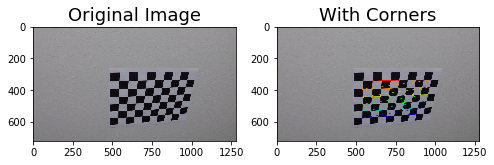

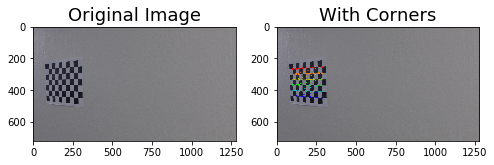

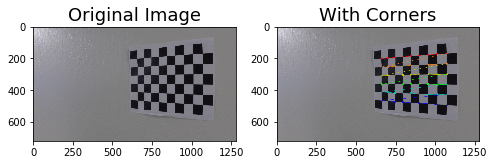

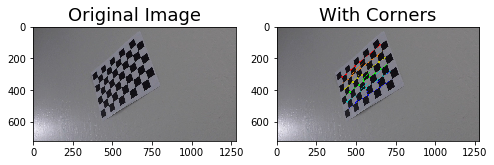

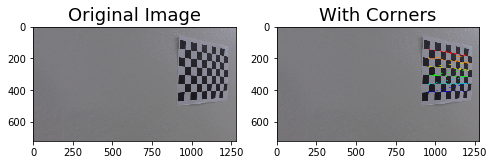

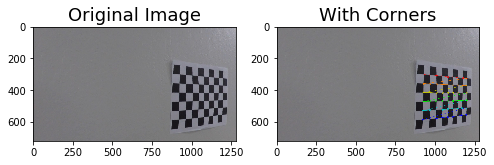

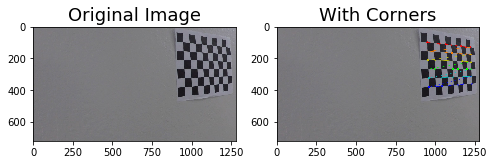

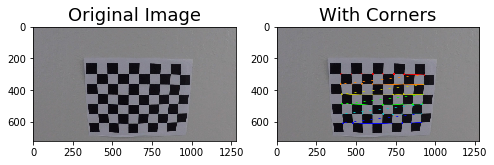

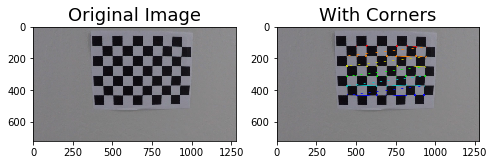

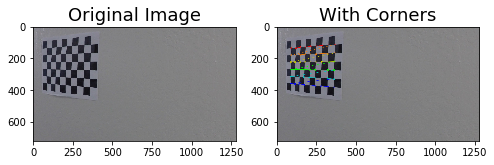

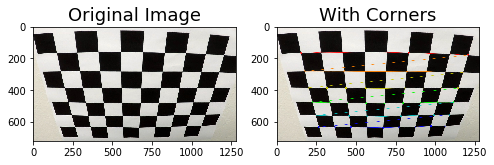

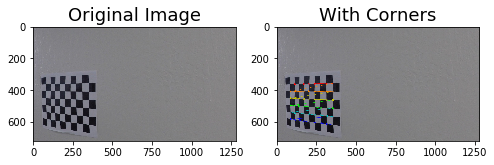

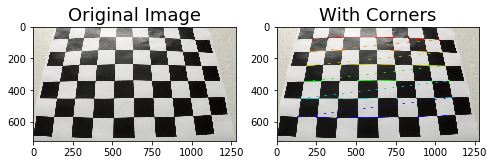

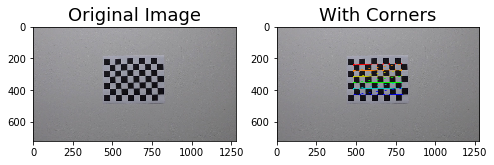

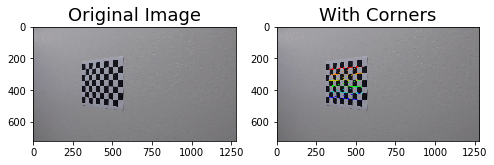

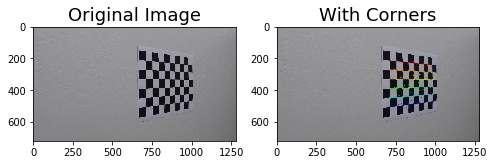

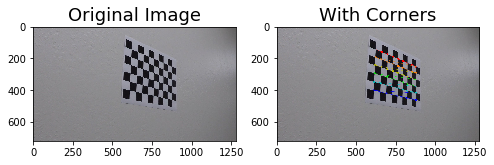

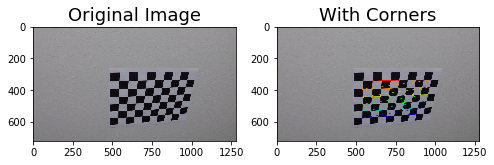

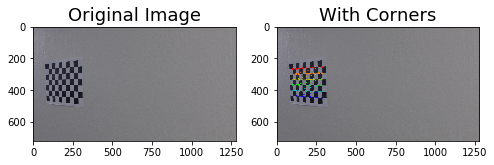

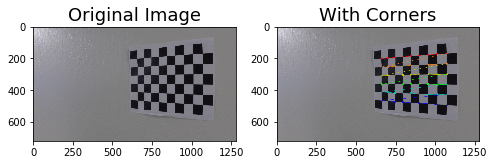

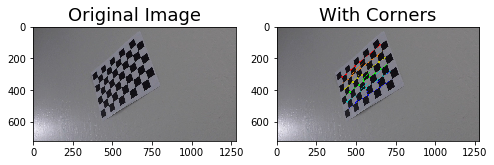

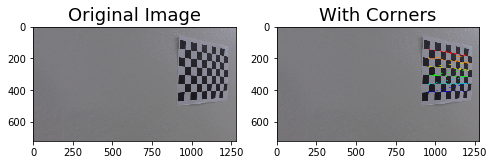

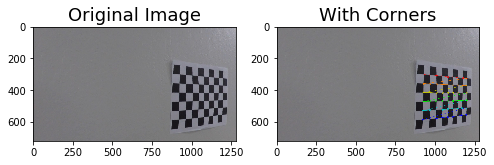

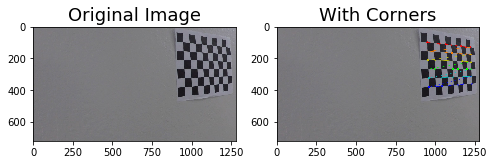

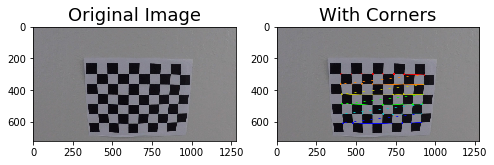

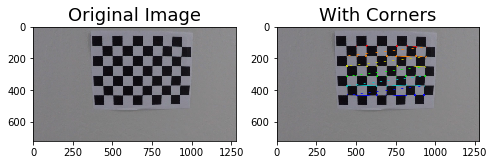

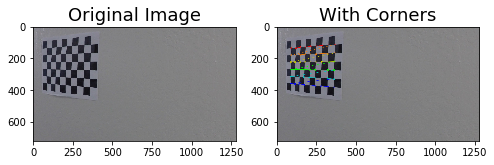

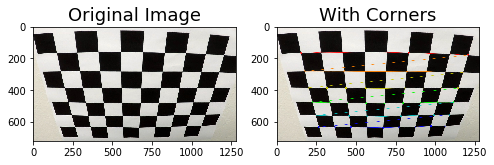

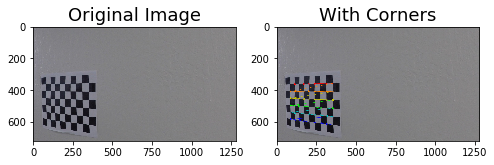

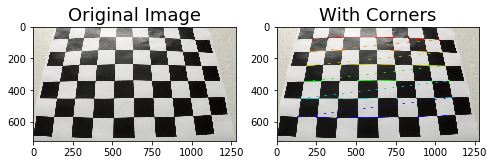

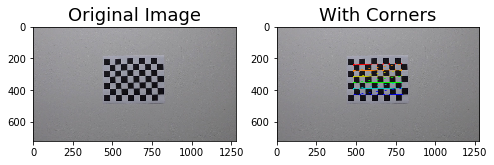

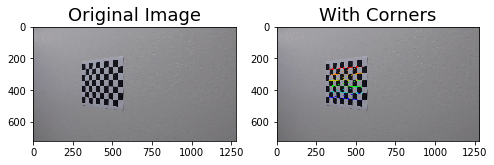

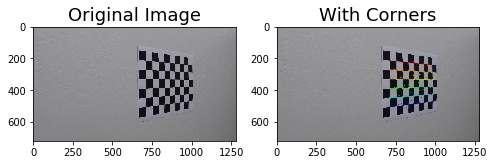

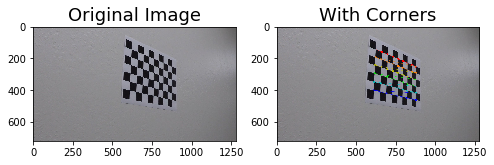

********************************************************************************
straight_lines1.jpg


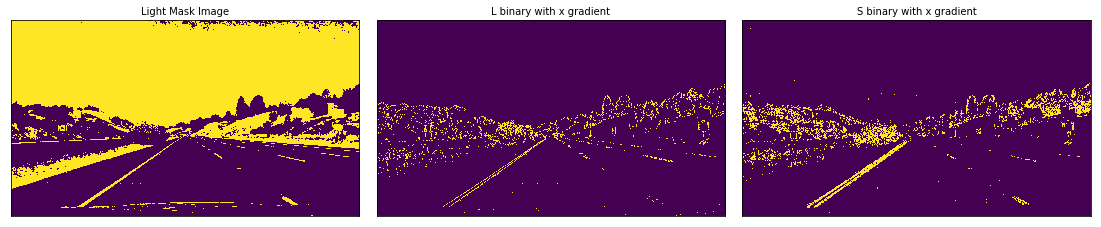

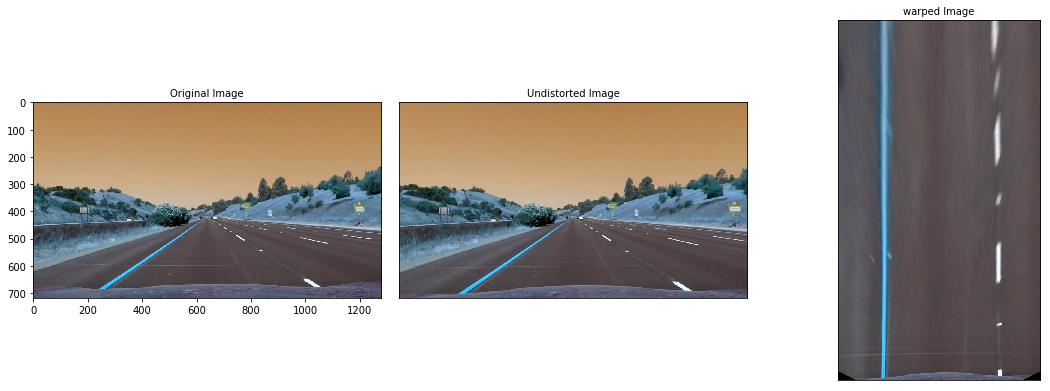

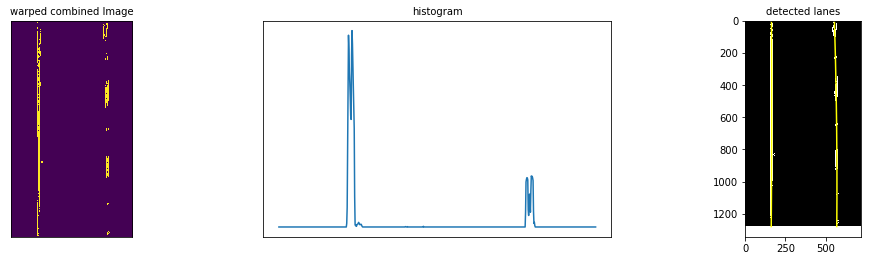

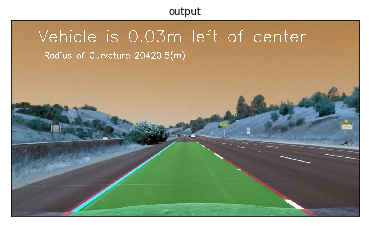

********************************************************************************
straight_lines2.jpg


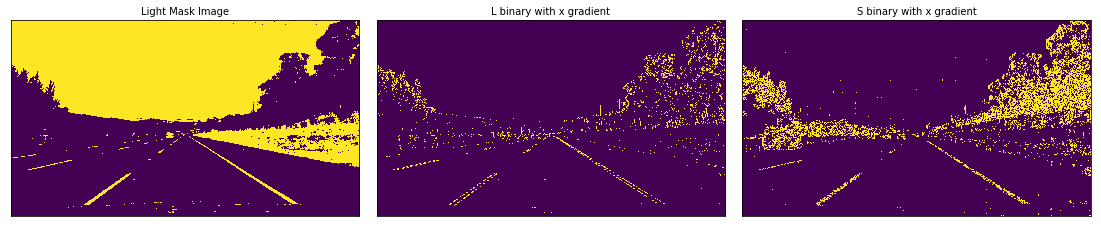

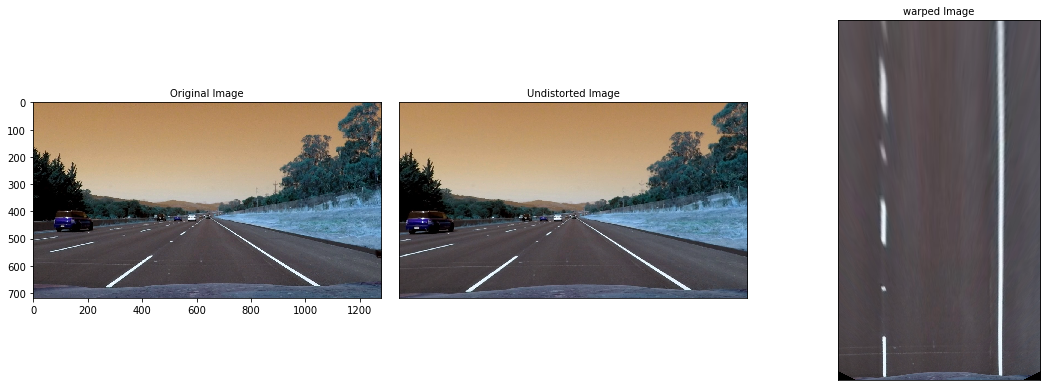

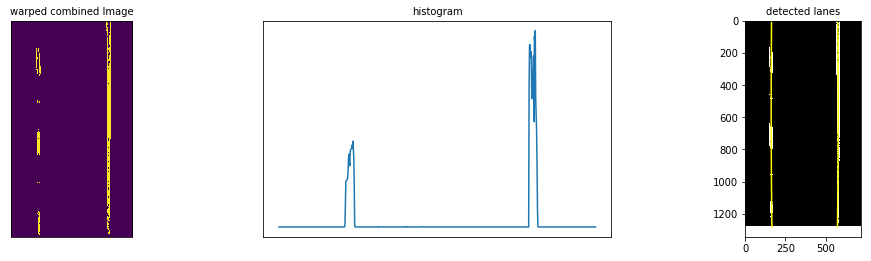

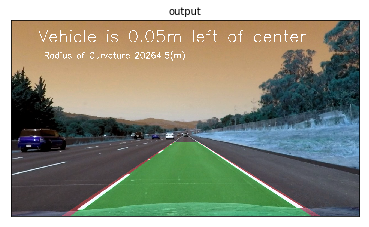

********************************************************************************
test1.jpg


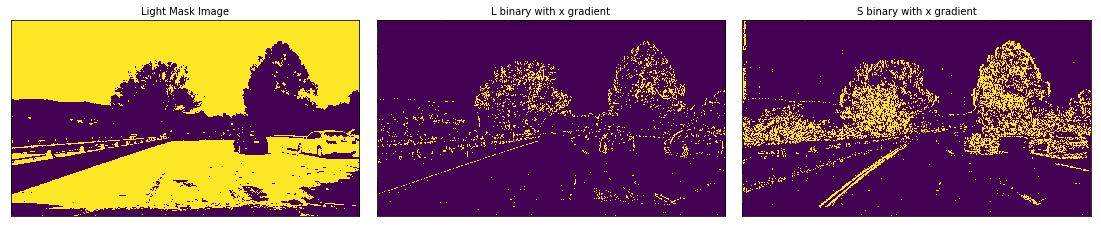

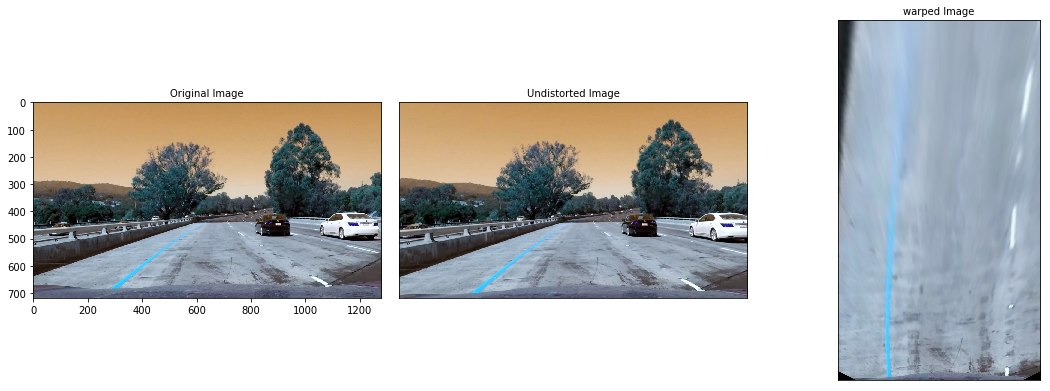

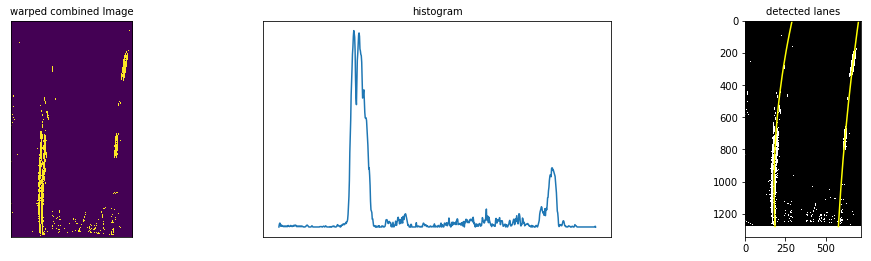

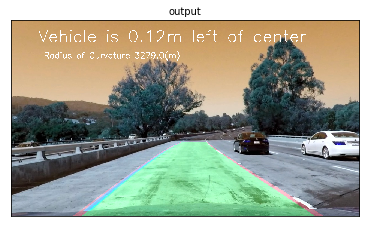

********************************************************************************
test2.jpg


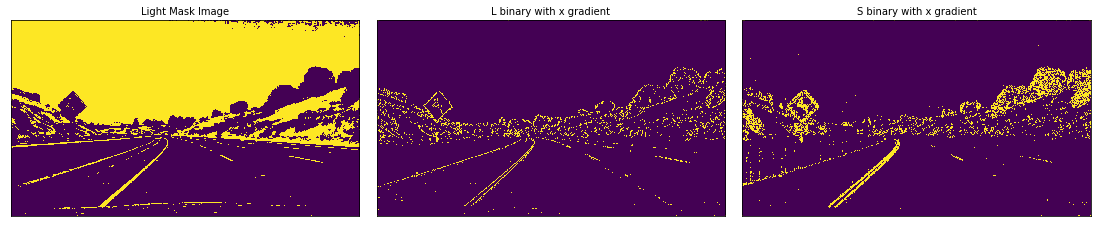

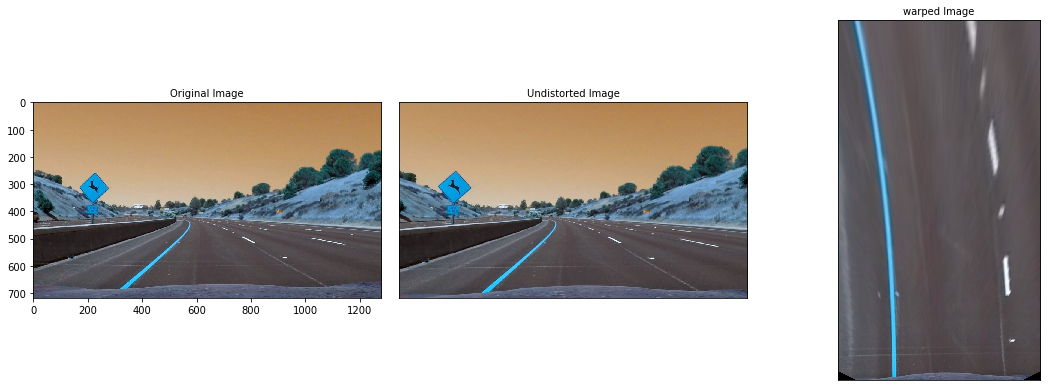

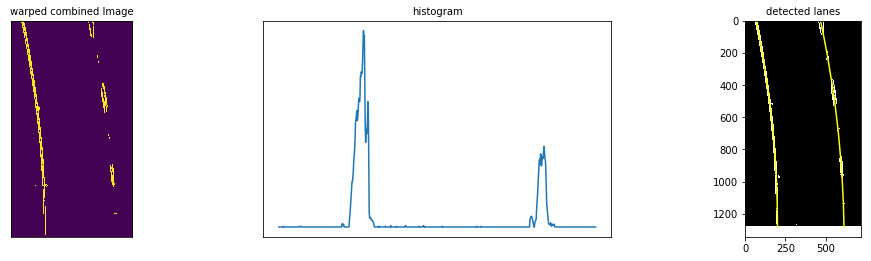

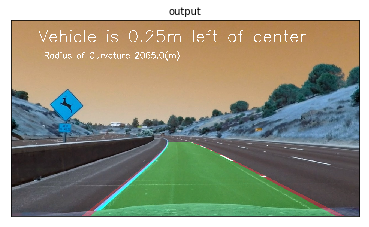

********************************************************************************
test3.jpg


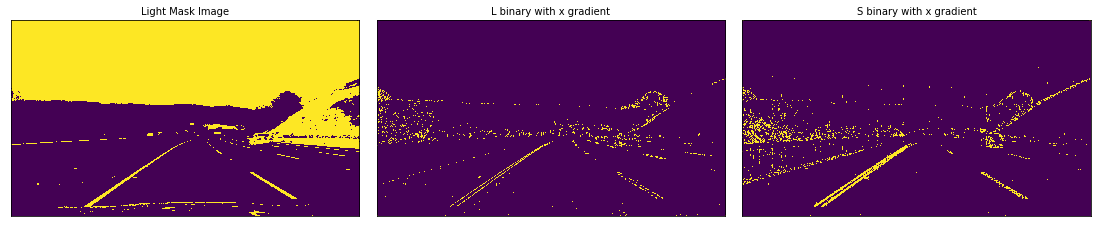

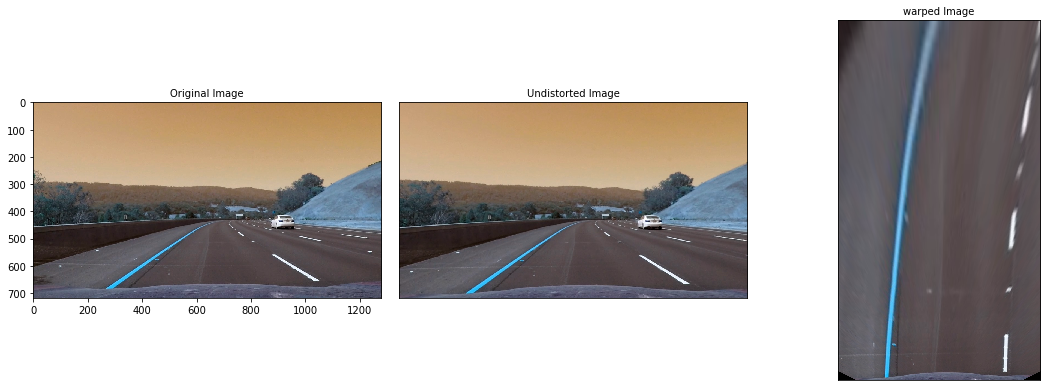

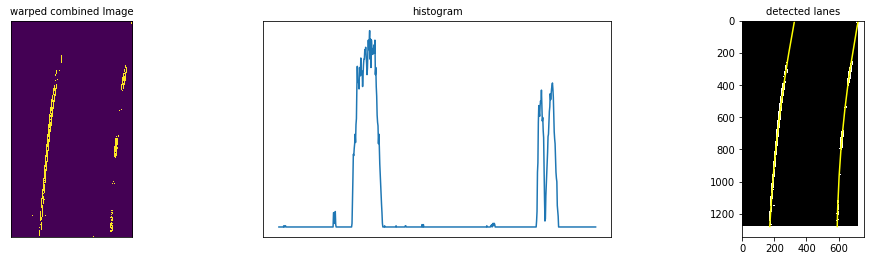

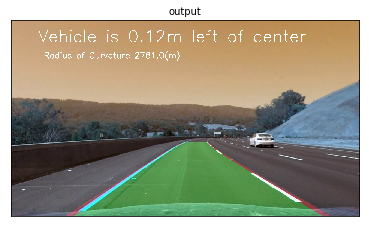

********************************************************************************
test4.jpg


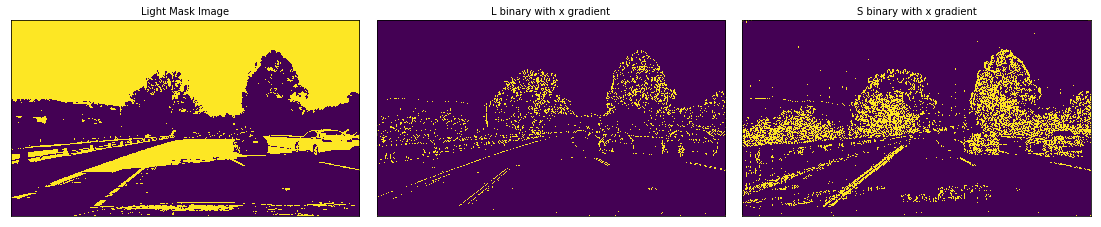

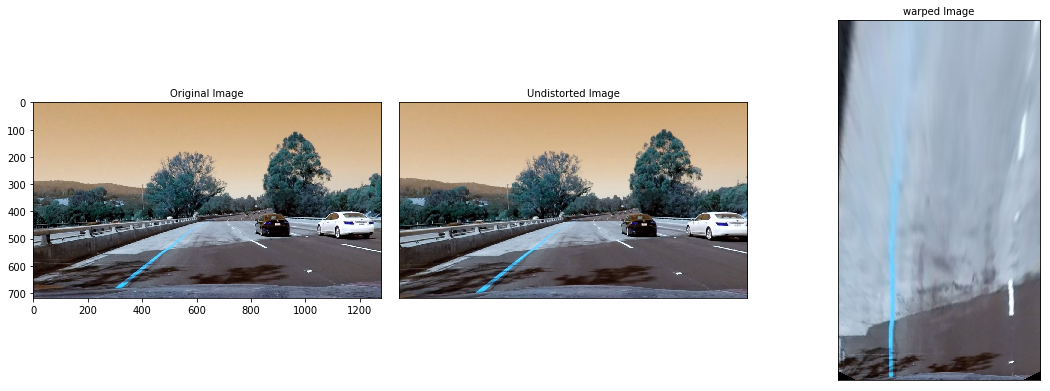

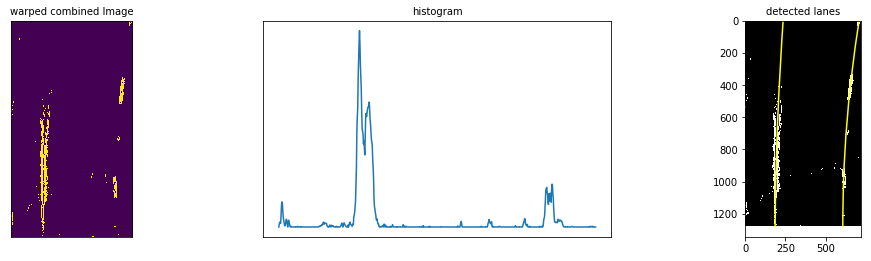

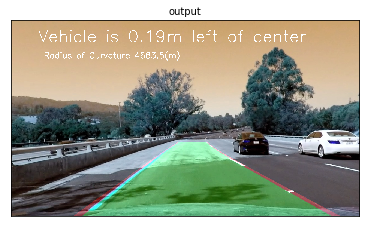

********************************************************************************
test5.jpg


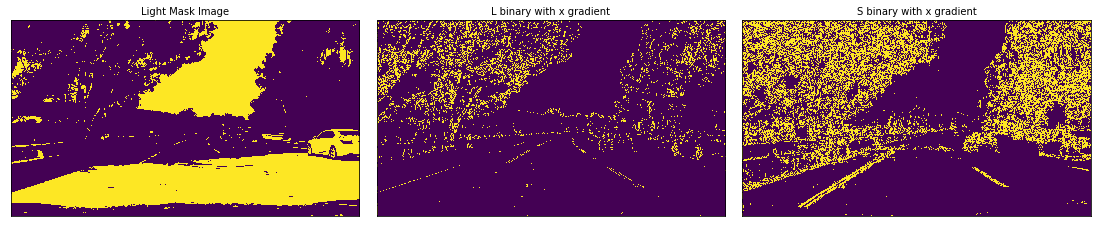

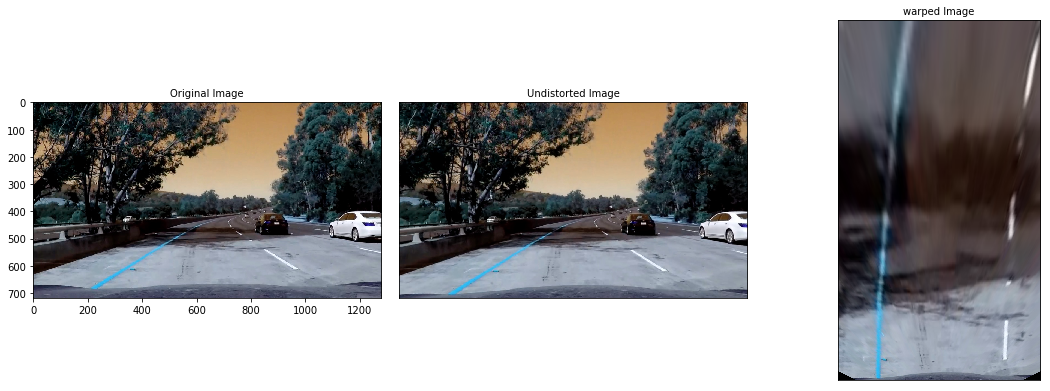

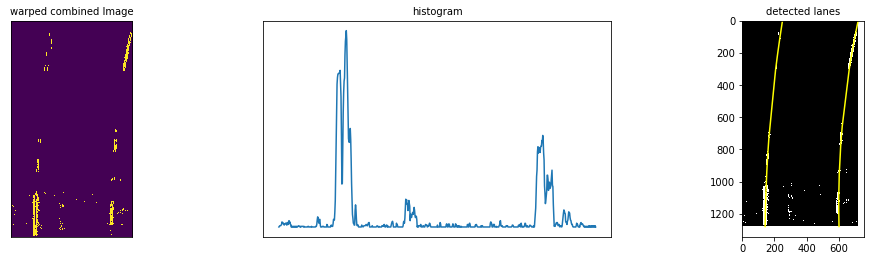

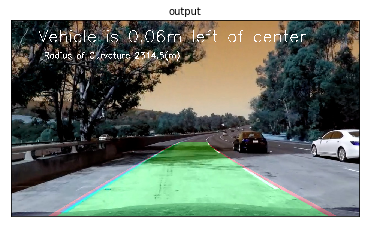

********************************************************************************
test6.jpg


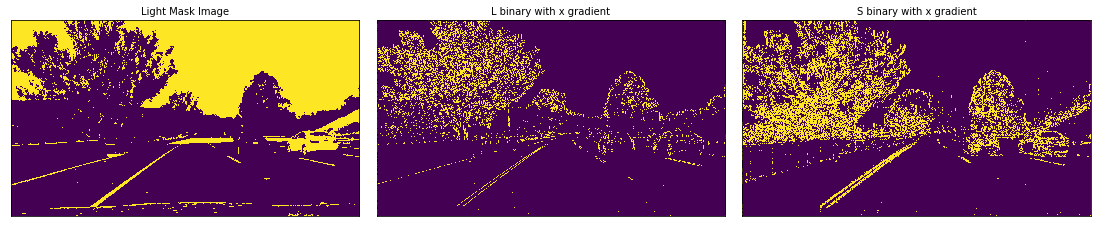

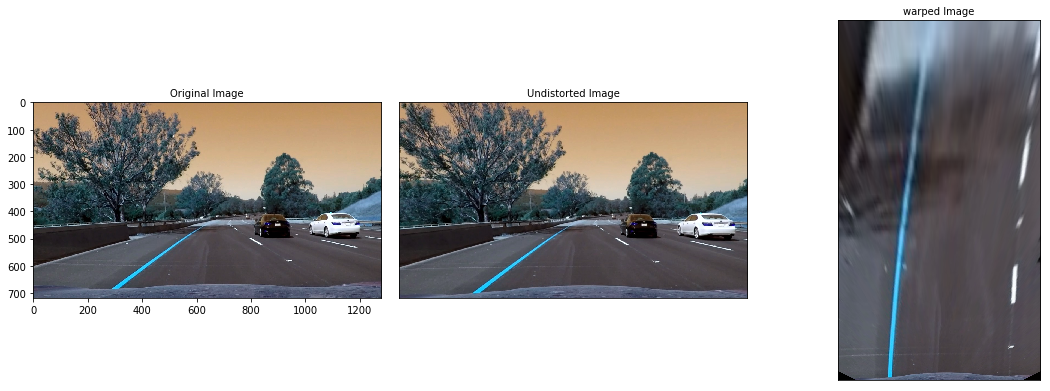

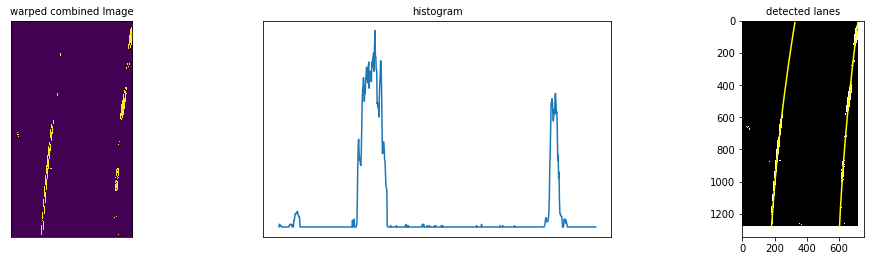

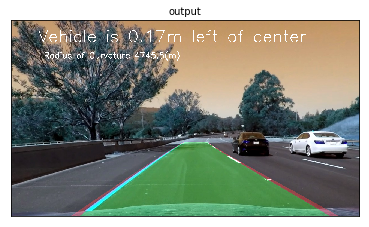

In [22]:
import os

objpoints, imgpoints = get_object_and_image_points()
plt.show()

global DEBUG

DEBUG = True

for image_name in os.listdir("./test_images"):
    image = cv2.imread("./test_images/%s" % image_name)
    
    Left_lane = Line()
    Right_lane = Line()
    
    print ("*" * 80)
    print (image_name)
    
    fig = plt.figure(figsize = (15, 3))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    light_mask = np.zeros_like(L)
    light_mask[(S >= 5) & (L >= 125)] = 1

    # Apply each of the thresholding functions
    lx_binary = abs_sobel_grad_thresh(L, orient='x', sobel_kernel=grad_kernel, thresh=lx_threshold)
    sx_binary = abs_sobel_grad_thresh(S, orient='x', sobel_kernel=grad_kernel, thresh=sx_threshold)
    
    axis = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    axis.imshow(light_mask)
    axis.set_title('Light Mask Image', fontsize=10)
    
    axis = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    axis.imshow(lx_binary)
    axis.set_title('L binary with x gradient', fontsize=10)
    
    axis = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    axis.imshow(sx_binary)
    axis.set_title('S binary with x gradient', fontsize=10)

    image_processing_pipeline(image)

In [23]:
def process_image(image):
    result = image_processing_pipeline(image)
    return result

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(input_video_filepath, output_video_filepath):
    clip = VideoFileClip(input_video_filepath)
    processed_clip = clip.fl_image(process_image)
    %time processed_clip.write_videofile(output_video_filepath, audio=False)

In [25]:
videos_to_process = [
                    ("./project_video.mp4", "./output/project_video.mp4"),
                    ("./challenge_video.mp4", "./output/challenge_video.mp4"),
                    ("./harder_challenge_video.mp4", "./output/harder_challenge_video.mp4")
                    ]
for input_video, output_video in videos_to_process[:-2]:
    Left_lane = Line()
    Right_lane = Line()
    global DEBUG
    DEBUG = False
    process_video(input_video, output_video)

[MoviePy] >>>> Building video ./output/project_video.mp4
[MoviePy] Writing video ./output/project_video.mp4


100%|█████████▉| 1260/1261 [3:52:25<00:01,  1.98s/it]    


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/project_video.mp4 

CPU times: user 37min 20s, sys: 1min 1s, total: 38min 21s
Wall time: 3h 52min 27s


In [26]:

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('./output/project_video.mp4'))